In [515]:
import numpy as np
import IPython.display as ipd  
import matplotlib.pyplot as plt
import networkx as nx
from functools import reduce

fs = 48000
pi = np.pi

In [516]:
pick = lambda n : lambda x : x[0][:,n][:,np.newaxis]
const = lambda n : lambda x : n
mult = lambda x : reduce((lambda u, v: u * v), x)
plus = lambda x : x[0] + x[1]
minus = lambda x : x[0] - x[1]
divide = lambda x : x[0] / x[1]
wav = lambda x : np.sin(2*pi*x[0])
exp = lambda x : np.exp(x[0])
log = lambda x : np.log(x[0])
merge = lambda x : np.sum(x[0],axis=0)
H = lambda x : np.heaviside(x[0],0.5)
idy = lambda x : x[0]

x = lambda x : np.arange(0,10,1/fs)
y = lambda x : np.array([[1,200,0,0.01],[1,400,1,0.01],[0.5,300,2,0.01],
                         [0.5,240,3,0.01],[1,200,4,0.01],[1,150,5,0.01],
                         [1,200,6,0.01],[0.5,200,7,0.01],[1/3,200,8,0.01],
                         [1,250,9,0.01]])

In [517]:
def invert(f):
    
    inverse_pairs = [[plus,minus],[mult,divide],[exp,log]]
    for pair in inverse_pairs:
        if f in pair:
            return pair[pair.index(f) - 1]

In [525]:
func_list = [('x',x),('y',y),('A',pick(0)),('f',pick(1)),
             ('R',pick(2)),('cutoff',pick(3)),('mult0',mult),('minus0',minus),
             ('-1',const(-1)),('mult1',mult),('wav',wav),('exp',exp),
             ('minus1',minus),('H0',H),('H1',H),('mult2',mult),
             ('merge',merge)]

edge_list = [('x','mult0',{'order': 0}),('x','minus0',{'order': 0}),('y','f',{'order': 0}),
             ('y','R',{'order': 0}),('y','cutoff',{'order': 0}),('y','A',{'order': 0}),
             ('f','mult0',{'order': 1}),('R','minus0',{'order': 1}),('cutoff','minus1',{'order': 1}),
             ('A','mult2',{'order': 0}),('mult0','wav',{'order': 0}),('minus0','H0',{'order': 0}),
             ('minus0','mult1',{'order': 0}),('-1','mult1',{'order': 1}),('mult1','exp',{'order': 0}),
             ('wav','mult2',{'order': 1}),('exp','minus1',{'order': 0}),('minus1','H1',{'order': 0}),
             ('H0','mult2',{'order': 2}),('H1','mult2',{'order': 3}),('exp','mult2',{'order': 4}),
             ('mult2','merge',{'order': 0})]

dict_list = [{'func': f[1], 'value': None} for f in func_list]
node_list = list(zip([f[0] for f in func_list],dict_list))

G = nx.DiGraph()

G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

def compute(G):
    
    T = list(nx.topological_sort(G))
    
    for f in T:
        preds = list(G.predecessors(f))
        inputs = [G.nodes[p]['value'] for p in preds]
        orders = [G[p][f]['order'] for p in preds]
        ordered_inputs = [x for _,x in sorted(zip(orders,inputs))]
        G.nodes[f]['value'] = G.nodes[f]['func'](ordered_inputs)
        
    return G.nodes[T[-1]]['value']

In [526]:
H_gen = ((n,f) for (n,f) in G.nodes.data('func') if f==H)
for (n,f) in H_gen:
    ans = nx.ancestors(G,n)
    ans.add(n)
    Hg = G.subgraph(ans).copy()
    paths = list(nx.all_simple_paths(G,'x',n))
    if len(paths) == 1:
        edges_to_flip = Hg.subgraph(paths[0]).copy().edges.data('order')
        Hg.remove_edges_from([(a,b) for (a,b,c) in edges_to_flip])
        Hg.add_edges_from([(b,a,{'order':c}) for (a,b,c) in edges_to_flip] )
        for node in paths[0]:
            Hg.nodes[node]['func'] = invert(Hg.nodes[node]['func'])
        Hg.nodes[n]['func'] = lambda x : (0,False)
    print(Hg.nodes.data('func'))
                

[('H0', <function <lambda> at 0x10acf85e0>), ('y', <function <lambda> at 0x10acf8ea0>), ('x', None), ('R', <function <lambda>.<locals>.<lambda> at 0x10acf8360>), ('minus0', <function <lambda> at 0x10acfb1a0>)]
[('x', None), ('y', <function <lambda> at 0x10acf8ea0>), ('R', <function <lambda>.<locals>.<lambda> at 0x10acf8360>), ('cutoff', <function <lambda>.<locals>.<lambda> at 0x10acfaca0>), ('minus0', <function <lambda> at 0x10acfb1a0>), ('-1', <function <lambda>.<locals>.<lambda> at 0x10a59c860>), ('mult1', <function <lambda> at 0x10acf9d00>), ('exp', <function <lambda> at 0x10acf8220>), ('minus1', <function <lambda> at 0x10acfb1a0>), ('H1', <function <lambda> at 0x10acf85e0>)]


In [506]:
ipd.display(ipd.Audio(out, rate=fs))  

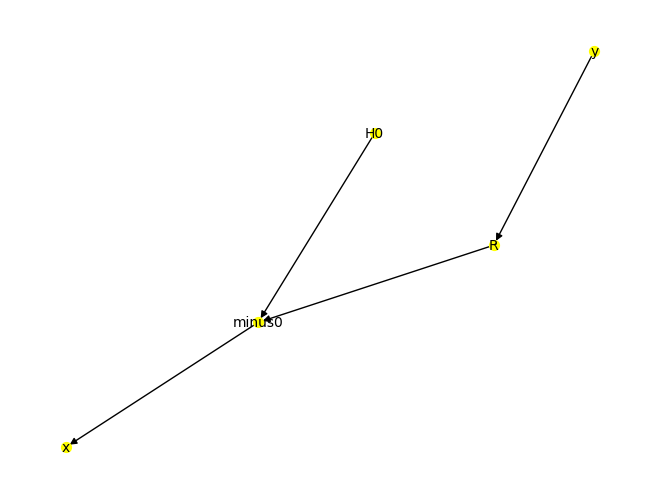

In [507]:
options = {
    'node_size': 50,
    'font_size': 10,
    'node_color': 'yellow'
}
nx.draw(Hg, with_labels=True, **options)